In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [30]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

# Téléchargement des données et premier traitement

In [31]:
coords_grenoble = (45.1973288, 5.7139923)

startday = pd.to_datetime('12/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime('24/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')

## Météo Darksky
J'utilise l'API de DarkSky (https://darksky.net).

In [32]:
# routine pour construire automatiquement un dataframe pandas:
# télécharge les données en ligne
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, done


Ce sont des données heure par heure. Pour avoir une meillieur précision avec les données mesurées et le flux solaire, on augmente artificiellment la fréquence à 15min:

In [34]:
weatherdata = weatherdata.resample('15min').interpolate('linear')

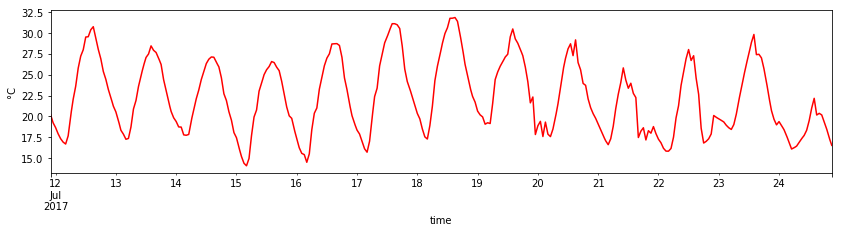

In [35]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

## Irradiation solaire

Routine permettant d'obtenir :

* Le flux (W/m2) sur une surface perpendiculaire au rayon du soleil, en prennant en compte la couverture nuageuse.
* La position du soleil (altitude et azimuth) pour projeter sur les vitres ensuite. 

Il n'y a pas la radiation diffuse, mais prend en compte la couverture nuageuse ( $ 0.75*c^3.4 $ ... )

In [36]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


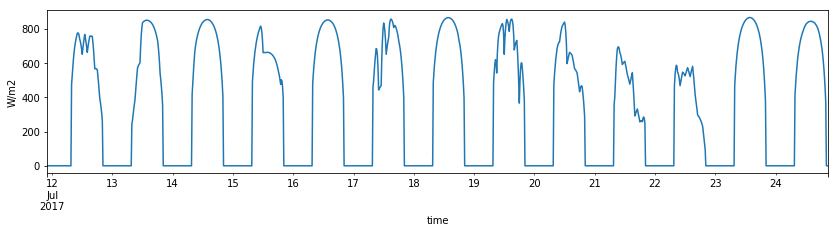

In [37]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');

### Projection sur les surfaces vitrées

In [38]:
# surface (m2),  sigma (deg),  azimuth (deg)
windows = { 'bastille':(1.2*0.8,    37, 50) ,
            'cuisine':(0.3*0.72 *2, 90, 50 ),
            'chambre':(0.3*0.72 *2, 90, 180+50),
            'vercors':(0.6*0.8 * 2, 37, 180+50) }

In [39]:
sunFlux_dict = {}

for k, values in windows.items():
    sunFlux_dict['flux_'+k] = values[0] * sun.projectDF( values[1], values[2], sundata )

flux_tot = pd.DataFrame( sunFlux_dict )

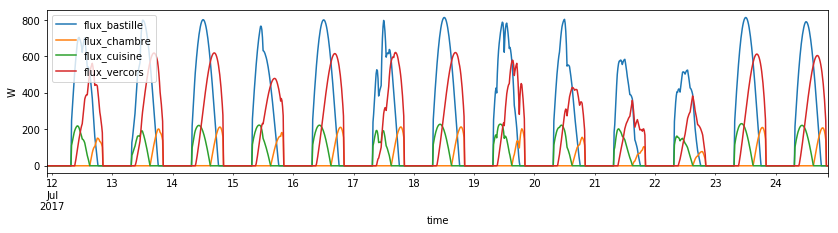

In [40]:
flux_tot.plot(figsize=(14, 3)); plt.ylabel('W');

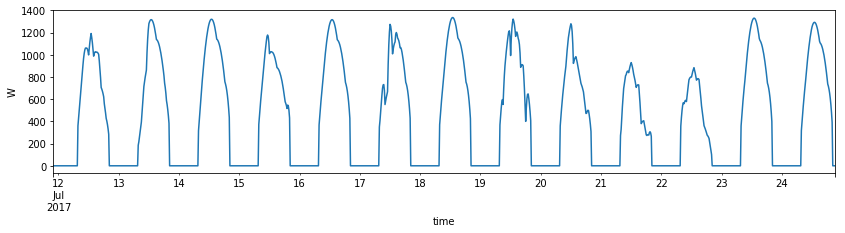

In [41]:
# Somme
weatherdata['flux_tot'] = flux_tot.sum(axis=1)

weatherdata['flux_tot'].plot( figsize=(14, 3) ); plt.ylabel('W');

**Rq:** C'est le flux 'brut' reçu par les surfaces. Il faut ensuite prendre en compte la réflexion, l'absorption et la ré-émission ... ceci étant décrit par un facteur multiplicatif entre 0 et 1, noté facteur_g. [wiipedia](https://fr.wikipedia.org/wiki/Vitre#Le_facteur_solaire_g_ou_transmission_.C3.A9nerg.C3.A9tique)

Au minimum, on a $facteur_g = 0.76$ pour un double vitrage. Il y a aussi l'absorption par le cadre (et les rideaux) et la transmision par conduction, et re-émissions. 


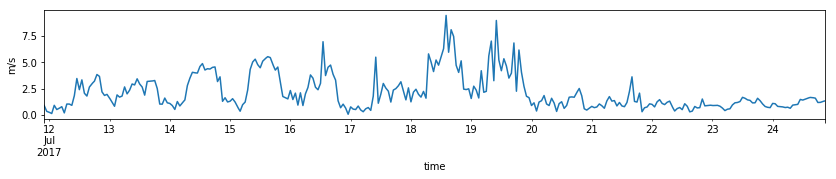

In [42]:
# Vitesse du vent
weatherdata['windSpeed'].plot(figsize=(14, 2));  plt.ylabel('m/s');

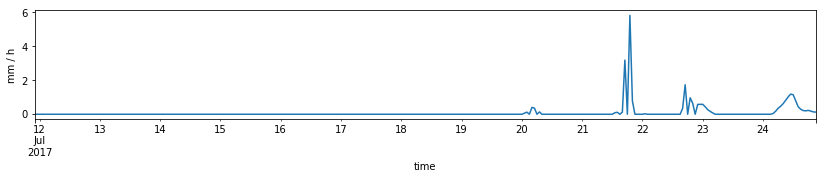

In [43]:
# Pluie
weatherdata['precipIntensity'].plot(figsize=(14, 2)); plt.ylabel('mm / h');

# Température intérieure mesurée

Lecture CSV depuis EmonCMS

In [44]:
parser = lambda d: pd.to_datetime( int( d ), unit='s' )

In [45]:
Tmesure = pd.read_csv('./data_weektest/3.csv', sep=',', index_col=0, parse_dates=True, \
                 header=None, names=['T_int',], date_parser=parser)

# Resample
Tmesure = Tmesure.resample('15min').mean()

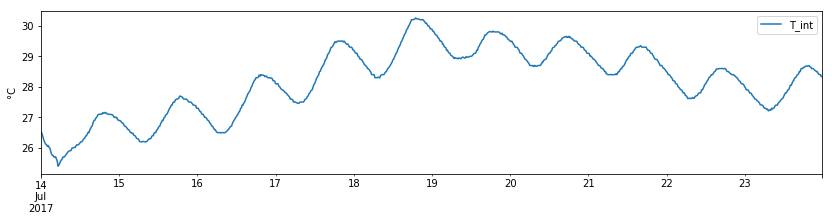

In [46]:
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [47]:
# Remove some data 
mask_start = pd.to_datetime( '14/07/2017 12:00' ).tz_localize('Europe/Paris')
mask_end = pd.to_datetime( '24/07/2017 12:00' ) .tz_localize('Europe/Paris')

mask = (Tmesure.index < mask_start) | (Tmesure.index > mask_end )

Tmesure['T_int'].loc[mask] = np.nan

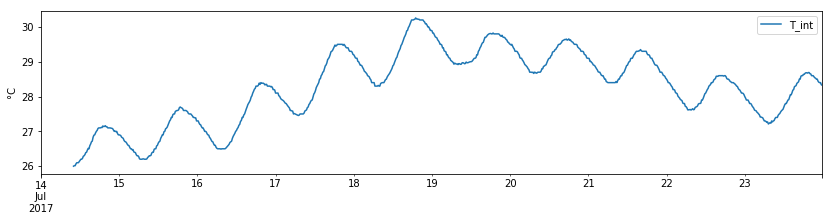

In [48]:
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [49]:
# Merge
weatherdata['T_int'] = Tmesure['T_int']

# Enregistrement du Dataframe avec  Pickle

In [50]:
weatherdata.to_pickle( 'weektest_data.pck' )

# Graph

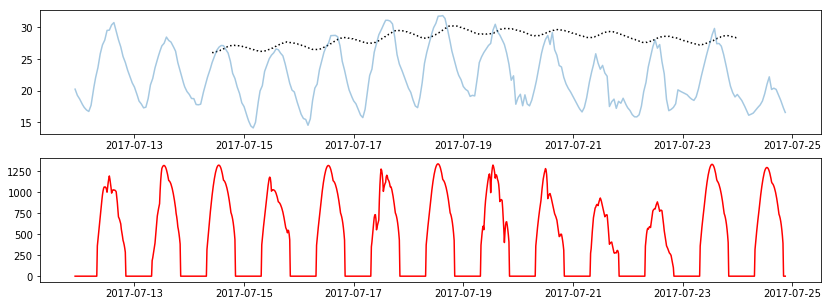

In [51]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot(weatherdata['T_int'] , ':k')
plt.plot(weatherdata['temperature'], alpha=0.4);

plt.subplot( 2, 1, 2 )
plt.plot(weatherdata['flux_tot'] , 'r'); 


# Météo blue data

In [53]:
filename = 'data_weektest/'+'history_export_2017-07-24T18_14_12.csv'

In [94]:
data = pd.read_csv(filename, sep=';' , header=10)

data.index = pd.to_datetime( data[['Year', 'Month', 'Day', 'Hour', 'Minute']] )
data = data.drop( ['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1 )



In [95]:
data.columns

Index(['Temperature  [2 m above gnd]', 'Relative humidity  [2 m above gnd]',
       'Mean Sea Level Pressure  [MSL]', 'Total Precipitation  [sfc]',
       'Total cloud cover  [sfc]', 'High cloud cover  [high cld lay]',
       'Medium cloud cover  [mid cld lay]', 'Low cloud cover  [low cld lay]',
       'Shortwave Radiation - backwards  [sfc]',
       'Wind speed  [10 m above gnd]', 'Wind direction  [10 m above gnd]',
       'Wind Gust  [sfc]'],
      dtype='object')

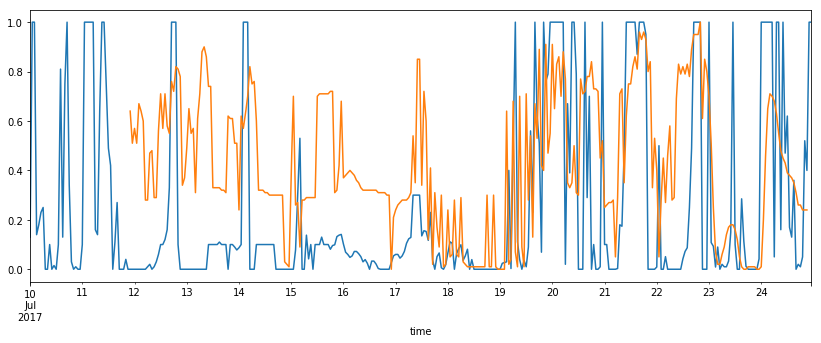

In [97]:
plt.figure( figsize=(14, 5) )

clouCover_blue = data['Total cloud cover  [sfc]'] / 100
clouCover_blue.plot()
weatherdata['cloudCover'].plot()

In [82]:
surf_tot = sum( [ w[0] for w in windows.values() ] ) 

In [83]:
approx_rad  = data['Shortwave Radiation - backwards  [sfc]'] * surf_tot / 2

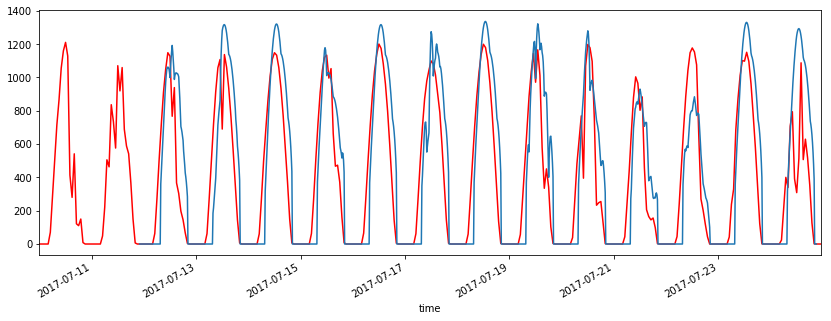

In [84]:
plt.figure( figsize=(14, 5) )

plt.plot( approx_rad, 'r')
weatherdata['flux_tot'].plot()

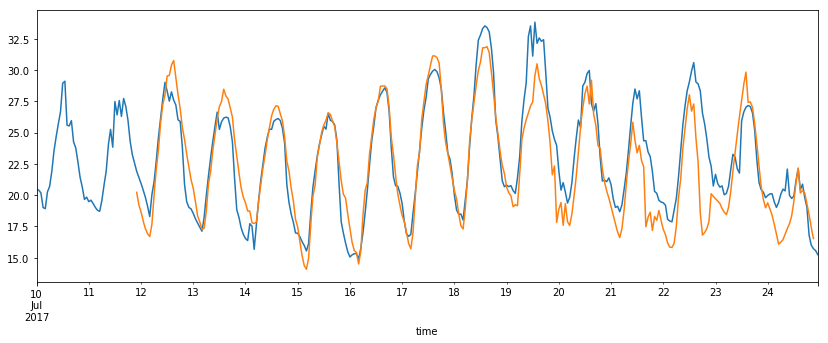

In [67]:
plt.figure( figsize=(14, 5) )

data['Temperature  [2 m above gnd]'].plot()
weatherdata['temperature'].plot()

In [ ]:
weatherdata.precipIntensity

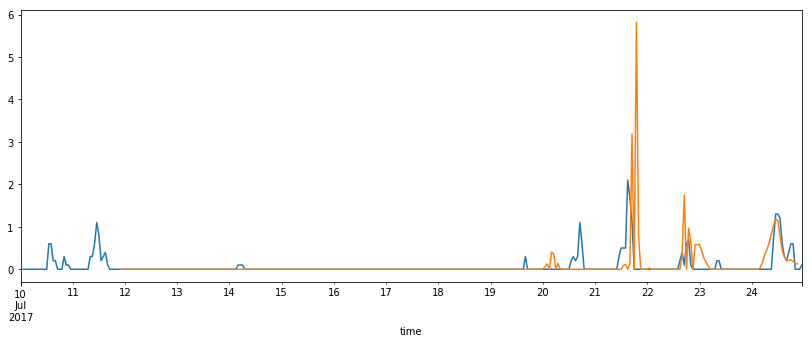

In [69]:
plt.figure( figsize=(14, 5) )

data['Total Precipitation  [sfc]'].plot()
weatherdata['precipIntensity'].plot()

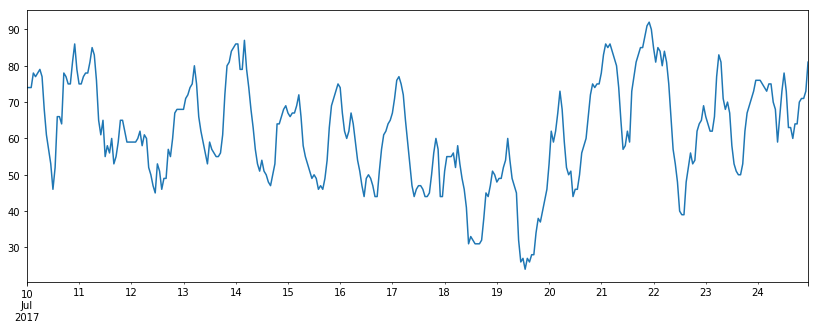

In [86]:
plt.figure( figsize=(14, 5) )

data['Relative humidity  [2 m above gnd]'].plot()

In [113]:
cloudcover_blue = data['Total cloud cover  [sfc]'].resample('15min').interpolate() / 100

In [114]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = cloudcover_blue )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


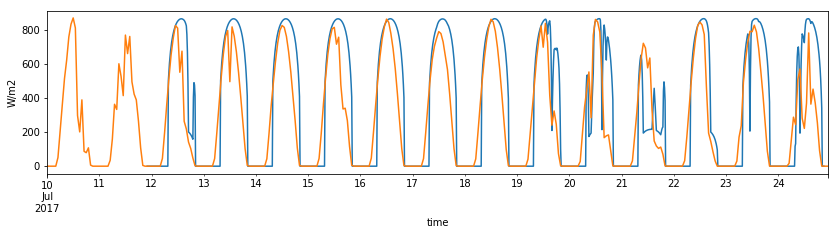

In [118]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');
data['Shortwave Radiation - backwards  [sfc]'].plot()

In [116]:
cloudcover_blue

2017-07-10 00:00:00    0.1300
2017-07-10 00:15:00    0.3475
2017-07-10 00:30:00    0.5650
2017-07-10 00:45:00    0.7825
2017-07-10 01:00:00    1.0000
2017-07-10 01:15:00    1.0000
2017-07-10 01:30:00    1.0000
2017-07-10 01:45:00    1.0000
2017-07-10 02:00:00    1.0000
2017-07-10 02:15:00    0.7850
2017-07-10 02:30:00    0.5700
2017-07-10 02:45:00    0.3550
2017-07-10 03:00:00    0.1400
2017-07-10 03:15:00    0.1500
2017-07-10 03:30:00    0.1600
2017-07-10 03:45:00    0.1700
2017-07-10 04:00:00    0.1800
2017-07-10 04:15:00    0.1925
2017-07-10 04:30:00    0.2050
2017-07-10 04:45:00    0.2175
2017-07-10 05:00:00    0.2300
2017-07-10 05:15:00    0.2350
2017-07-10 05:30:00    0.2400
2017-07-10 05:45:00    0.2450
2017-07-10 06:00:00    0.2500
2017-07-10 06:15:00    0.1875
2017-07-10 06:30:00    0.1250
2017-07-10 06:45:00    0.0625
2017-07-10 07:00:00    0.0000
2017-07-10 07:15:00    0.0000
                        ...  
2017-07-24 15:45:00    0.0900
2017-07-24 16:00:00    0.0000
2017-07-24